First, you need to get your data in a certain format:
 - videos or stimuli can be `time` by `x` by `y` numpy arrays, or `1` by `channel` by `time` by `x` by `y`.
 - all sequences have to have the same sampling frequency (bin-length)
 - if you want to fit a spike train and you only have the spike times, you need to convert them into a time sequence

For this example we get a sample pair of input and output (which is generated by a randomized LN model):



In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import convis
inp, out = convis.samples.generate_sample_data(input='random',size=(2000,20,20))
print(inp.shape)

/home/jacob_unencrypted/Environments/default/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


(2000, 20, 20)


Then, you need to choose a model, eg. an `LN` model as well.
For the `LN` cascade models in Convis, you can set a parameter `population`
depending on whether you have a single or multiple responses
that you want to fit.
If `population` is `True`, the model will output an image at the last
stage, if `population` is `False`, it will only return a time series.
Our sample output is an image with the same size as the input,
so `population` should be `True` (which is also the default).
We also choose the size of the kernel that is used for the convolution.


In [2]:
m = convis.models.LN(kernel_dim=(12,7,7),population=True)

We can have a look at how well our model is doing right now by looking
at the loss:

In [3]:
print(m.compute_loss(inp,out,dt=500))

[Variable containing:
 2.2804e+07
[torch.FloatTensor of size 1]
, Variable containing:
 2.2995e+07
[torch.FloatTensor of size 1]
, Variable containing:
 2.2903e+07
[torch.FloatTensor of size 1]
, Variable containing:
 2.2471e+07
[torch.FloatTensor of size 1]
]


The default loss function is the sum of squared errors, but any loss 
function can be used by supplying it as an argument.
Since we didn't fit the parameters so far, the loss will be pretty bad (around $10^7$).
`compute_loss` returns the loss for each chunk that is computed 
separately. You can add them up or take the mean using `np.sum` or `np.mean`.

Next, we will choose an optimizer. Which optimizer works best for you
will depend on the complexity of you model and the data you supply.
We recommend trying out different ones.
In this example, we will choose the Adam optimizer. A list of all optimizers
can be tab-completed in IPython and jupyter notebooks
when typing `m.set_optimizer.` and then pressing TAB.

In [4]:
m.set_optimizer.Adam()

Then, we can optimize the model using our complete input,
but separated into smaller chunks of length `dt` (to make 
sure everything fits into memory).
Most optimization algorithms need to be run more than once
since they only take small steps in the direction of the gradient.

In [5]:
for i in range(50):
    m.optimize(inp,out,dt=500)

We can examine the loss again after a few steps of fitting and also visualize the filters.
`convis.plot_5d_matshow` can plot a 5 dimensional filter as a sequence of images.
Since we created a filter spanning 12 frames, we see 10 little matrices, separated by a 1px border.

[Variable containing:
 1.5404e+07
[torch.FloatTensor of size 1]
, Variable containing:
 1.5538e+07
[torch.FloatTensor of size 1]
, Variable containing:
 1.5602e+07
[torch.FloatTensor of size 1]
, Variable containing:
 1.5322e+07
[torch.FloatTensor of size 1]
]


Text(0.5,1.05,u'Filter after fitting 50x Adam')

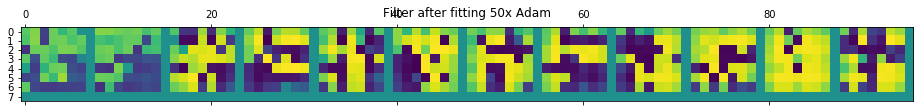

In [6]:
print(m.compute_loss(inp,out,dt=500))
convis.plot_5d_matshow(m.p.conv.weight)
plt.title('Filter after fitting 50x Adam')

The loss decreased, but not by much.

To compare this result visually to the true kernel of the sample data generator we can cheat a little and look at its parameter:

Text(0.5,1.05,u'Random Ground Truth Filter')

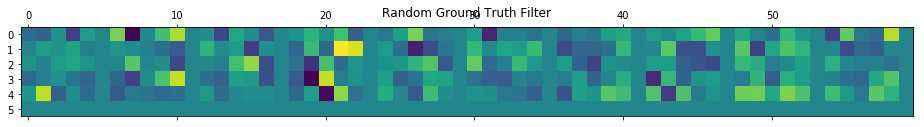

In [7]:
convis.plot_5d_matshow(convis.samples._g.conv.weight)
plt.title('Random Ground Truth Filter')

Let's use a different algorithm to optimize our parameters.
`LBFGS` is a pseudo-Newton method and will evaluate the model
multiple times per step. 
We do not necessarily have to run it multiple times over the
data ourselves and in some cases running this optimizer too
often can deteriorate our solution again, as the small gradients
close to the real solution lead to numerical instabilities.

In [8]:
m.set_optimizer.LBFGS()
losses = m.optimize(inp,out,dt=500)
print('losses during fitting:')
print(losses)

losses during fitting:
[Variable containing:
 1.5404e+07
[torch.FloatTensor of size 1]
, Variable containing:
 3001.8110
[torch.FloatTensor of size 1]
, Variable containing:
 3003.5098
[torch.FloatTensor of size 1]
, Variable containing:
 2974.9736
[torch.FloatTensor of size 1]
]


Did we improve?

[Variable containing:
1.00000e+05 *
  3.0521
[torch.FloatTensor of size 1]
, Variable containing:
 2527.1201
[torch.FloatTensor of size 1]
, Variable containing:
 2523.0732
[torch.FloatTensor of size 1]
, Variable containing:
 2473.7632
[torch.FloatTensor of size 1]
]


Text(0.5,1.05,u'Filter after fitting with LBFGS')

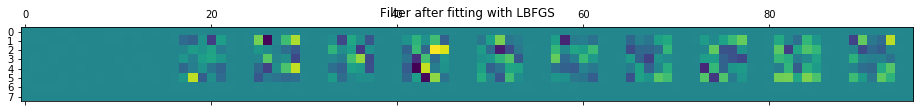

In [9]:
print(m.compute_loss(inp,out,dt=500))
convis.plot_5d_matshow(m.p.conv.weight)
plt.title('Filter after fitting with LBFGS')

We can see clearly now that the size of our fitted kernel does not match the sample generator, which makes sense, since we normally don't have access to a ground-truth at all. But our model just set the border pixels and the first two frames to 0.

You can use impulse responses to quickly compare Models
independent of their kernel sizes.
(however, for more complex models this will not capture 
the complete model response):

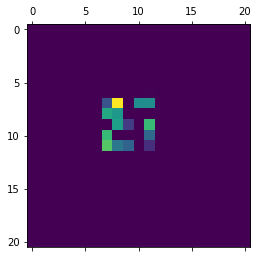

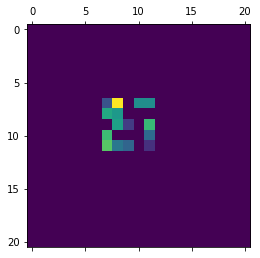

In [10]:
m.plot_impulse_space()
convis.samples._g.plot_impulse_space()

Finally, you can save the parameters into a 
compressed numpy file.

In [11]:
m.save_parameters('fitted_model.npz')